**Analyzing the impact of prescribed burns and climate on wildfire size**

**Sequoia Andrade**


# Introduction

With climate change-driven large, destructive wildfires becoming more frequent, especially in California, using data to identify predictors of wildfire destruction can provide insight onto the influences of this trend. Additionally, identifying effective prevention methods, such as prescribed burns, can inform future preparations. Numerous datasets have been made public in recent years, including detailed tree-level data from national parks in addition to incident reports from large wildfire events. Statistical data science methods provide tools for making sense of the immense heterogeneous data relevant to wildfires. In this project, I will analyze predictors of wildfire acres burned in California using supervised statistical and machine learning techniques. This report covers data preprocessing and model building. 

# Data Preprocessing

The dataset used in this project was manually created by bridging three main data sources: the Calfire record of wildfire incidents, the record of prescribed burn incidents, and climate data collected by NOAA. The resulting dataset used in this project contains a row for wildfire incident, spaning from 2016-2022, with variables for location, size, and county. Columns include climate data (precipitation, soil moisture, temperature, and drought index) for the month before the fire and temporal-spatial prescribed fire information. For each incident, we identify if a prescribed fire occurred within in a specified time and spatial radius and record the sum of prescribed acres burned. This results in columns for each combination fo 3 month, 6 month, 12 month, 24 month, and 36 month time frame for spatial radii of 5 km, 10 km, 25 km, 50 km, and 100 km. The resulting data set hac 1740 rows and 69 columns.

Prior to training models, the data undergoes preprocessing. First, the target variable of wildfire acres burned is transformed using log transform. A corrlation matrix of selected predictors and the target variable is shown in Figure 1. As seen in the figure, many of the predictors are correlated with each other. Prior to using linear models, correlated predictors are reomved using the variation inflation factor (VIF). VIF is calculated for the entire set of predictors except for the prescribed fire variables, with initial scores in Table 1. Next, variables with the highest VIF are removed sequentially until all variables have a VIF around 1, resulting in the scores in Table 2. Since the climate variables had the most multicolinearity, the drought index (PZI) is chosen for its ease of interpretation and since it encompasses the other climate variahles. Before model training, each variable is scaled to the range of 0-1 using min-max scaling in the equation below:

$$x_{ij}^* = \frac{max(x_i)-x_{ij}}{max(x_i) - min(x_i)}$$

The minimum and maximum values from the scaling are caluclated using the training set, then used to transform the test set and validation sets with values larger than the max being set to 1 and values smaller than the min being set to 0. 

**Figure 1:** Correlation matrix for target and potential predictors 
<img src='figures/cm.png' >


**Table 1:** Variation inflation factor for potential predictors

\begin{array}{cc}
\hline \\
feature &  VIF \\
\hline \\
\text{incident longitude} & 321.387000 \\
\text{incident latitude} & 228.842000 \\
\text{soil moisture} & 40.908000 \\
\text{temp avg Value} & 3781766.698000 \\
\text{temp min Value} & 611582.028000 \\
\text{temp max Value} & 1369400.292000 \\
\text{precip new Value} & 4.949000 \\
\text{pdsi Value} & 26.726000 \\
\text{phdi Value} & 51.896000 \\
\text{pmdi Value} & 80.255000 \\
\text{pzi Value} & 5.835000 \\
\text{prescribed 3 months size 10km} & 1.400000 \\
\text{prescribed 3 months size 50km} & 2.108000 \\
\text{prescribed 6 months size 10km} & 1.443000 \\
\text{prescribed 6 months size 50km} & 6.691000 \\
\text{prescribed 12 months size 50km} & 6.251000 \\
\text{prescribed 24 months size 50km} & 13.236000 \\
\text{prescribed 36 months size 50km} & 12.031000 \\

\hline 
\end{array}

**Table 2:** Variation inflation factor for subset of predictors

\begin{array}{cc}
\hline \\
feature &  VIF \\
\hline \\
\text{pzi Value} & 1.024000 \\
\text{prescribed 3 months size 10km} & 1.317000 \\
\text{prescribed 6 months size 10km} & 1.333000 \\
\text{prescribed 12 months size 50km} & 1.056000 \\
\hline 
\end{array}

# Model Building: Wildfire Size

## Set-up

All models are trained and fine-tuned using 5 fold cross validation, with a test set used for final model evaluation. The data is split with 80% for training and cross validation and 20% for testing. The training and cross validation data is split again with 5 fold cross validation. The cross validation is primarily used to select the best parameters and predictors, while the test set is used to estimate how well the model generalizes. Once the best parameters for a model are selected using cross validation, the model is refit with the full training and validation dataset (80%) and evaluated on the test set. Model performace is measured using mean squared error, while $\lambda$ is chosen for penalty models using MSE. 

## Model Selection

At this point, six different models are selected for training and evaluation, including linear regression, mixed effect linear model, lasso regression, ridge regression, random forest, and adaboost with decision tree estimators. The linear models are useful for inference on the effect of each predictor on the target and provides easy interpretation for how changes in predictors impact the target. All linear models are fit with the full selected subset of predictors (pzi_Value, prescribed_3_months_size_10km , prescribed_6_months_size_10km, and prescribed_12_months_size_50km), then insignificant predictors are removed. Xgboost and random forest are also fit with the full subset of predictors, with best parameters selected using cross validation (max features, number of trees).

## Model Evaluation

The results from model training and evaluation are presented in Table 3. The ridge regression seems to perform the best with the lowest test error of 5.348, followed closely by the linear regression with 5.350 and lasso regression with 5.359. The mixed effects model performs the worst with an mse of 12.251 on the test set, followed by the random forest with 6.847 on the test set. The random forest appears to have overfit to the data since it has a much larger test error than training error.

**Table 3:** Model mean squared error on training and test set.
\begin{array}{ccc}
\hline \\ 
Model & Train MSE & Test MSE \\
\hline \\
\text{linear regression} & 4.939000 & 5.350000 \\
\text{linear mixed effects model} & 13.281000 & 12.251000 \\
\text{lasso} & 4.964000 & 5.359000 \\
\text{ridge} & 4.938000 & 5.348000 \\
\text{random forest} & 1.543000 & 6.847000 \\
\text{adaboost} & 4.891000 & 5.679000 \\
\hline
\end{array}

# Code

The code for this project is all in python and provided below

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sn
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from functions import crosscorrelations_target_single_plot
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv("prescribed_treatment_data_climate.csv", index_col=0)

In [3]:
df.columns

Index(['ex_date', 'incident_name', 'incident_county', 'incident_acres_burned',
       'incident_longitude', 'incident_latitude', 'incident_type',
       'prescribed_3_months_in_5km', 'prescribed_3_months_size_5km',
       'prescribed_3_months_in_10km', 'prescribed_3_months_size_10km',
       'prescribed_3_months_in_25km', 'prescribed_3_months_size_25km',
       'prescribed_3_months_in_50km', 'prescribed_3_months_size_50km',
       'prescribed_3_months_in_100km', 'prescribed_3_months_size_100km',
       'prescribed_6_months_in_5km', 'prescribed_6_months_size_5km',
       'prescribed_6_months_in_10km', 'prescribed_6_months_size_10km',
       'prescribed_6_months_in_25km', 'prescribed_6_months_size_25km',
       'prescribed_6_months_in_50km', 'prescribed_6_months_size_50km',
       'prescribed_6_months_in_100km', 'prescribed_6_months_size_100km',
       'prescribed_12_months_in_5km', 'prescribed_12_months_size_5km',
       'prescribed_12_months_in_10km', 'prescribed_12_months_size_10km',


<Axes: ylabel='Count'>

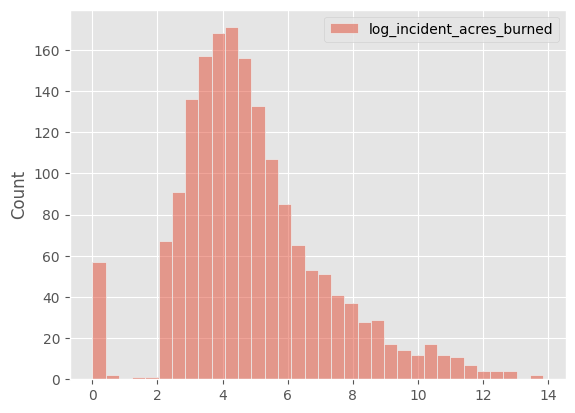

In [4]:
sn.histplot(df[["log_incident_acres_burned"]])

In [5]:
df["pzi_prescribed_3month_10km"] = [df.at[i,"prescribed_3_months_size_10km"]*df.at[i,'pzi_Value'] for i in range(len(df))]

In [6]:
df["constant"] = [1 for i in range(len(df))]

In [7]:
df = df.dropna(subset=["incident_county"]).reset_index(drop=True)

In [8]:
df["county_new"] = ["multiple" if len(str(county).split(","))>1 else county for county in df["incident_county"]]

In [9]:
potential_features = ['incident_longitude', 'incident_latitude', 'soil moisture', 'temp_avg_Value',
                    'temp_min_Value', 'temp_max_Value', 'precip_new_Value', 'pdsi_Value', 'phdi_Value', 'pmdi_Value',  'pzi_Value', 
                    "prescribed_3_months_size_10km", "prescribed_3_months_size_50km",
                    "prescribed_6_months_size_10km", "prescribed_6_months_size_50km",
                    "prescribed_12_months_size_50km", "prescribed_24_months_size_50km",
                     "prescribed_36_months_size_50km"]

In [10]:
county_regions = {
    "North Coast": ['Del Norte', 'Humboldt', 'Mendocino', "Sonoma", "Lake", "Napa", "Marin", "Trinity"],
    "Shasta Cascades": ['Siskiyou', "Trinity", "Shasta", "Lassen", "Modoc",
                        'Tehama', "Butte", "Plumas", "State of Oregon"],
    "Central Valley": ["Glenn", "Colusa", "Sutter","Yolo", "Sacramento", "Solano", "Fresno", "Kern", "Kings",
                       "Madera", "Merced", "Placer", "San Joaquin", "Tehama", "Yuba", "Stanislaus"],
    "Sierras": ["Alpine", "Amador", "Calaveras", "El Dorado", "Inyo", "Mariposa", "Mono", "Nevada", "Plumas", "Sierra", "Tulare",
                "Tuolumne", "State of Nevada"],
    "Central Coast": ["Contra Costa", "Alameda", "San Fransisco", "San Mateo", "Santa Clara",
                      "Santa Cruz", "San Benito", "Monterey", "San Luis Obispo", "Santa Barbara", "Ventura"],
    "South Coast": ["Los Angeles", "Orange", "San Diego"],
    "Desert": ["Riverside", "San Bernardino", "Imperial", "Mexico"],
    "Multiple": ["multiple"]
}

In [11]:
regions_per_county = {v: k for k, val in county_regions.items() for v in val}

In [12]:
df["county_new"] = [regions_per_county[county] for county in df["county_new"].to_list()]

<Axes: xlabel='county_new'>

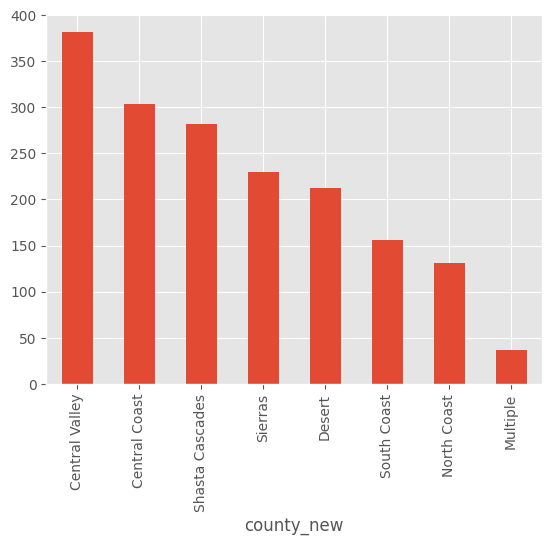

In [13]:
df["county_new"].value_counts().plot(kind='bar')

In [14]:
df["county_cat"] = pd.factorize(df["county_new"])[0]

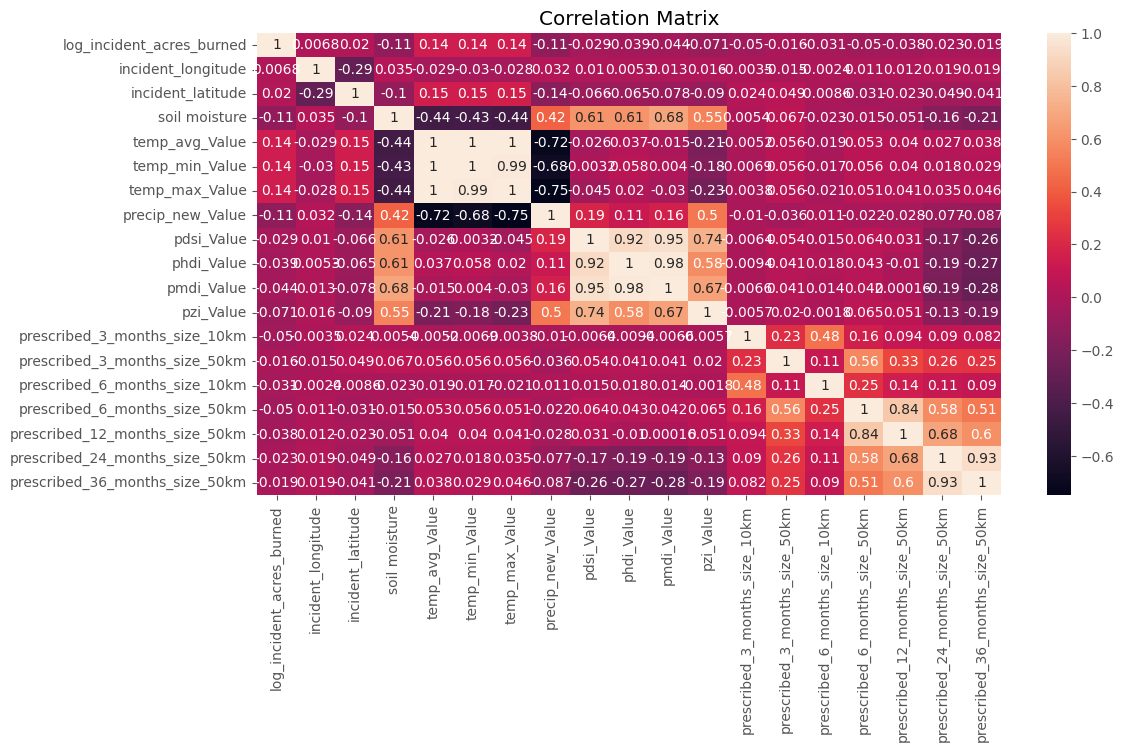

In [15]:
corr_matrix = df[["log_incident_acres_burned"]+potential_features].corr()
plt.figure(figsize=(12,6))
sn.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [16]:
vif_data = pd.DataFrame()
input_df = df[potential_features]
vif_data["feature"] = input_df.columns
vif_data["VIF"] = [round(variance_inflation_factor(input_df.values, i),3)
                          for i in range(len(input_df.columns))]
vif_data.set_index("feature")

,VIF
feature,
incident_longitude,320.567
incident_latitude,229.402
soil moisture,41.082
temp_avg_Value,3777426.257
temp_min_Value,610794.152
temp_max_Value,1368045.894
precip_new_Value,4.966
pdsi_Value,26.758
phdi_Value,51.969


In [17]:
df = pd.concat([df, pd.get_dummies(df["county_new"])], axis=1)

In [18]:
selected_features = ['pzi_Value',  "prescribed_3_months_size_10km", "prescribed_3_months_size_50km", "prescribed_6_months_size_10km", #"prescribed_6_months_size_50km",
                    "prescribed_12_months_size_50km"] 
selected_linear_features = ['pzi_Value',  "prescribed_6_months_size_10km"] + list(county_regions.keys())
selected_linear_m_features = ['pzi_Value',  "prescribed_6_months_size_10km"] 

In [19]:
vif_data = pd.DataFrame()
input_df = df[selected_features]
vif_data["feature"] = input_df.columns
vif_data["VIF"] = [round(variance_inflation_factor(input_df.values, i),3)
                          for i in range(len(input_df.columns))]
vif_data.set_index("feature")

,VIF
feature,
pzi_Value,1.031
prescribed_3_months_size_10km,1.381
prescribed_3_months_size_50km,1.323
prescribed_6_months_size_10km,1.335
prescribed_12_months_size_50km,1.277


In [20]:
print(vif_data.to_latex())

\begin{tabular}{llr}
\toprule
 & feature & VIF \\
\midrule
0 & pzi_Value & 1.031000 \\
1 & prescribed_3_months_size_10km & 1.381000 \\
2 & prescribed_3_months_size_50km & 1.323000 \\
3 & prescribed_6_months_size_10km & 1.335000 \\
4 & prescribed_12_months_size_50km & 1.277000 \\
\bottomrule
\end{tabular}



In [21]:
selected_features = selected_features + list(county_regions.keys())

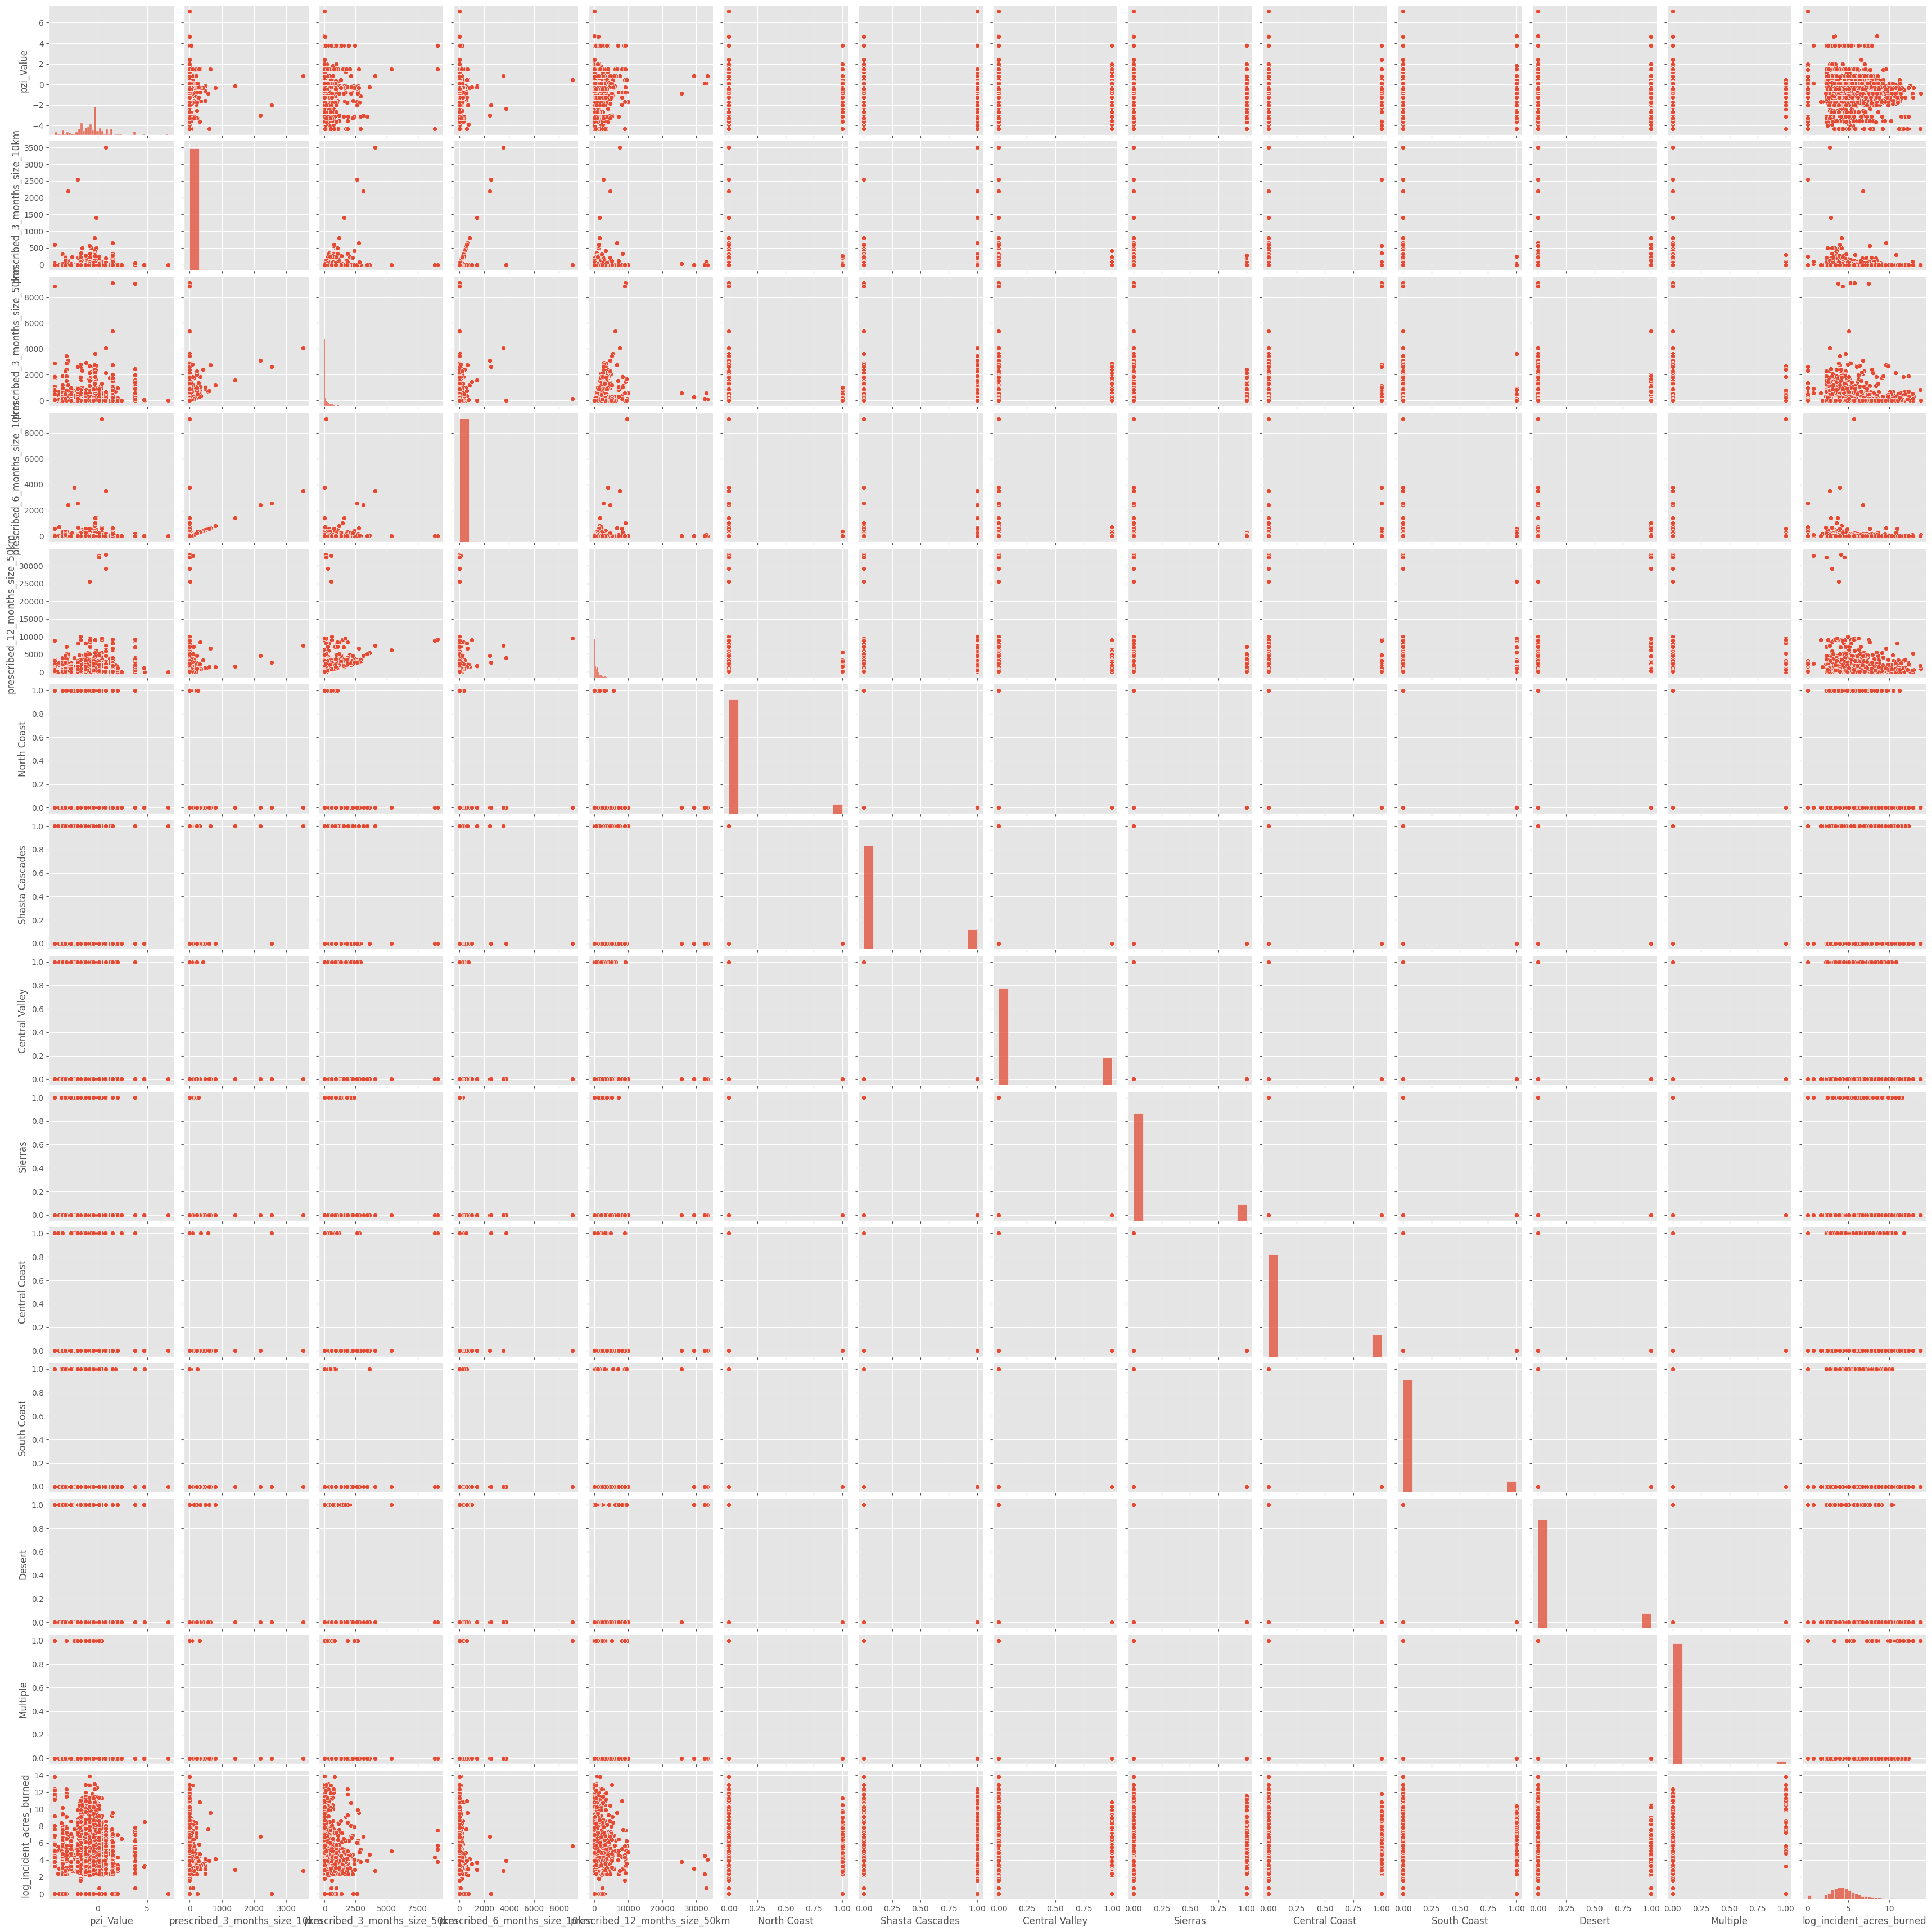

In [22]:
import seaborn as sns

sns.pairplot(df[selected_features+["log_incident_acres_burned"]])

In [23]:
# data storage
train_mse = []
test_mse = []

train_r = []
test_r = []

models = ["linear regression", "linear mixed effects model",  "lasso", "ridge", "random forest", "adaboost"]

In [24]:
# data preprocessing
train_val, test = train_test_split(df, test_size=0.2, train_size=0.8, random_state=1)

kf = KFold(n_splits=5, random_state=123, shuffle=True)

# min max scale
scaler = MinMaxScaler().fit(train_val[selected_features].fillna(0).astype(float))
x_train = pd.DataFrame(scaler.transform(train_val[selected_features].fillna(0).astype(float)), columns=selected_features)
x_test = pd.DataFrame(scaler.transform(test[selected_features].fillna(0).astype(float)), columns=selected_features)
y_train = train_val["log_incident_acres_burned"].reset_index(drop=True)
y_test = test["log_incident_acres_burned"].reset_index(drop=True)

scaler_lm = MinMaxScaler().fit(train_val[selected_linear_features].fillna(0).astype(float))
x_train_lm = pd.DataFrame(scaler_lm.transform(train_val[selected_linear_features].fillna(0).astype(float)), columns=selected_linear_features)
x_test_lm = pd.DataFrame(scaler_lm.transform(test[selected_linear_features].fillna(0).astype(float)), columns=selected_linear_features)
    

In [25]:
# linear regression
x_test_lm["constant"] = [1 for i in range(len(y_test))]
x_train_lm["constant"] = [1 for i in range(len(y_train))]
linear_model = sm.OLS(y_train, x_train_lm, missing='drop', hasconst=False).fit()
print(linear_model.summary())

train_mse.append(np.mean(np.power((linear_model.predict(x_train_lm) - y_train),2)))
test_mse.append(np.mean(np.power((linear_model.predict(x_test_lm) - y_test),2)))
train_r.append(r2_score(y_train, linear_model.predict(x_train_lm)))
test_r.append(r2_score(y_test, linear_model.predict(x_test_lm)))



                                    OLS Regression Results                                    
Dep. Variable:     log_incident_acres_burned   R-squared (uncentered):                   0.847
Model:                                   OLS   Adj. R-squared (uncentered):              0.846
Method:                        Least Squares   F-statistic:                              764.0
Date:                       Fri, 15 Dec 2023   Prob (F-statistic):                        0.00
Time:                               01:27:36   Log-Likelihood:                         -3004.2
No. Observations:                       1387   AIC:                                      6028.
Df Residuals:                           1377   BIC:                                      6081.
Df Model:                                 10                                                  
Covariance Type:                   nonrobust                                                  
                                    coef    std er

In [26]:
# mixed effects model

x_train_lmm = pd.concat([x_train_lm[selected_linear_m_features].astype(float), train_val[["county_cat"]].reset_index(drop=True)], axis=1).fillna(0)
x_test_lmm = pd.concat([x_test_lm[selected_linear_m_features].astype(float),test[["county_cat"]].reset_index(drop=True)], axis=1).fillna(0)
import statsmodels.formula.api as smf
x_test_lmm["constant"] = [1 for i in range(len(y_test))]
x_train_lmm["constant"] = [1 for i in range(len(y_train))]
md = sm.MixedLM(y_train, x_train_lmm[selected_linear_m_features+["constant"]], groups=x_train_lmm["county_cat"])
mdf = md.fit()
print(mdf.summary())
train_mse.append(np.mean(np.power((mdf.predict(x_train_lmm[selected_linear_m_features+["constant"]]) - y_train),2)))
test_mse.append(np.mean(np.power((mdf.predict(x_test_lmm[selected_linear_m_features+["constant"]]) - y_test),2)))
train_r.append(r2_score(y_train, mdf.predict(x_train_lmm[selected_linear_m_features+["constant"]])))
test_r.append(r2_score(y_test, mdf.predict(x_test_lmm[selected_linear_m_features+["constant"]])))


                 Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: log_incident_acres_burned
No. Observations:  1387    Method:             REML                     
No. Groups:        8       Scale:              4.4882                   
Min. group size:   29      Log-Likelihood:     -3024.7652               
Max. group size:   301     Converged:          Yes                      
Mean group size:   173.4                                                
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
pzi_Value                     -0.687    0.452 -1.521 0.128 -1.572  0.198
prescribed_6_months_size_10km -2.570    1.297 -1.981 0.048 -5.113 -0.027
constant                       5.608    0.661  8.487 0.000  4.313  6.903
Group Var                      3.294    0.868                        

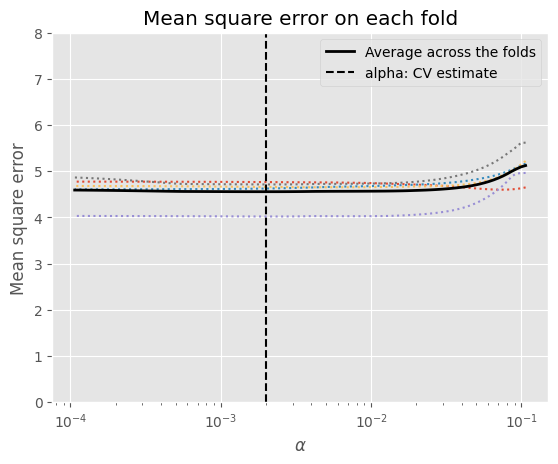

In [27]:
# lasso
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

model = LassoCV(cv=kf).fit(x_train, y_train)

ymin, ymax = 0.0001, 100
lasso = model
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(0, 8)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold"
)

In [28]:
lasso.alpha_

0.0019983673812197914

In [29]:
selected_features

['pzi_Value',
 'prescribed_3_months_size_10km',
 'prescribed_3_months_size_50km',
 'prescribed_6_months_size_10km',
 'prescribed_12_months_size_50km',
 'North Coast',
 'Shasta Cascades',
 'Central Valley',
 'Sierras',
 'Central Coast',
 'South Coast',
 'Desert',
 'Multiple']

In [30]:
lasso.coef_

array([-0.54847448, -0.        , -0.        , -1.49866432, -0.22159837,
       -0.44973987,  0.03563346,  0.18185387, -0.04952421, -0.19046923,
        0.        , -0.80319834,  4.95796835])

In [31]:
train_mse.append(np.mean(np.power((lasso.predict(x_train) - y_train),2)))
test_mse.append(np.mean(np.power((lasso.predict(x_test) - y_test),2)))
train_r.append(r2_score(y_train, lasso.predict(x_train)))
test_r.append(r2_score(y_test, lasso.predict(x_test)))

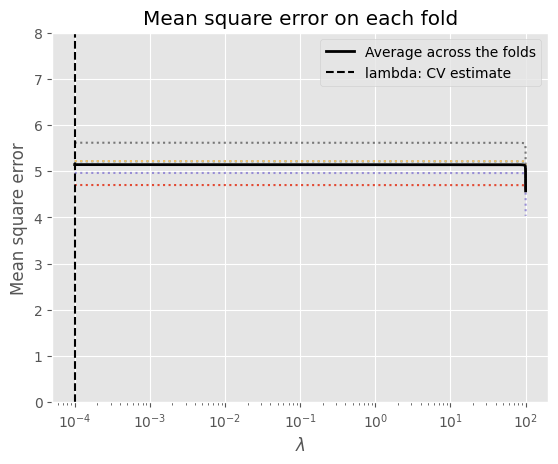

In [32]:
# ridge
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.pipeline import make_pipeline

alphas = np.linspace(0.0001, 100, 1000)
model = ElasticNetCV(cv=kf, l1_ratio=0.00001, alphas=alphas, max_iter=100000).fit(x_train, y_train)
ridge = model
plt.semilogx(alphas, ridge.mse_path_, linestyle=":")
plt.plot(
    alphas,
    ridge.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(ridge.alpha_, linestyle="--", color="black", label="lambda: CV estimate")

plt.ylim(0, 8)
plt.xlabel(r"$\lambda$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold"
)

In [33]:
ridge.alpha_

0.0001

In [34]:
x_train.columns

Index(['pzi_Value', 'prescribed_3_months_size_10km',
       'prescribed_3_months_size_50km', 'prescribed_6_months_size_10km',
       'prescribed_12_months_size_50km', 'North Coast', 'Shasta Cascades',
       'Central Valley', 'Sierras', 'Central Coast', 'South Coast', 'Desert',
       'Multiple'],
      dtype='object')

In [35]:
ridge.coef_

array([-0.64413253, -0.40789186, -0.05044193, -2.14570216, -0.5624802 ,
       -0.953715  , -0.41386029, -0.28142613, -0.5314669 , -0.67003765,
       -0.44974511, -1.26594348,  4.56625508])

In [36]:
train_mse.append(np.mean(np.power((ridge.predict(x_train) - y_train),2)))
test_mse.append(np.mean(np.power((ridge.predict(x_test) - y_test),2)))
train_r.append(r2_score(y_train, ridge.predict(x_train)))
test_r.append(r2_score(y_test, ridge.predict(x_test)))

In [37]:
# random forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid={'n_estimators': [100, 200, 300, 400, 500], "max_features":["sqrt", "log2", None]}
rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=kf, scoring='neg_mean_squared_error')
rf = rf.fit(x_train, y_train)
rf.get_params()


{'cv': KFold(n_splits=5, random_state=123, shuffle=True),
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(),
 'n_jobs': None,
 'param_grid': {'n_estimators': [100, 200, 300, 400, 500],
  'max_features': ['sqrt', 'log2', None]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'neg_mean_squared_error',
 'verbose': 0}

In [38]:
rf.best_score_

-5.089610757831249

In [39]:
rf.best_estimator_

RandomForestRegressor(max_features='sqrt', n_estimators=300)

In [40]:
rf = rf.best_estimator_
rf = rf.fit(x_train, y_train)
train_mse.append(np.mean(np.power((rf.predict(x_train) - y_train),2)))
test_mse.append(np.mean(np.power((rf.predict(x_test) - y_test),2)))
train_r.append(r2_score(y_train, rf.predict(x_train)))
test_r.append(r2_score(y_test, rf.predict(x_test)))

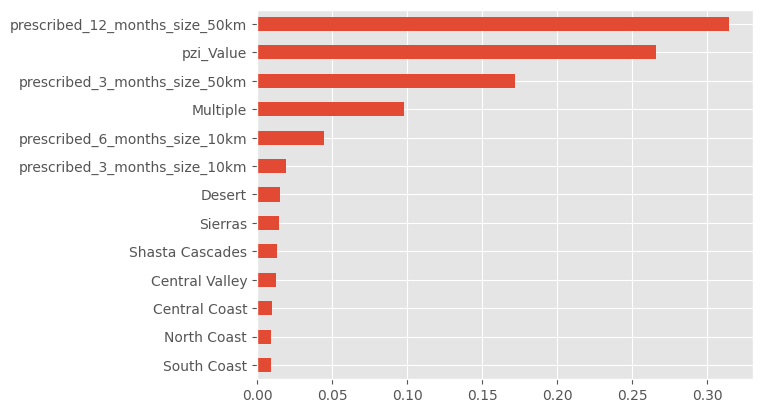

In [41]:
feat_importances = pd.Series(rf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(len(selected_features)).plot(kind='barh').invert_yaxis()

In [42]:
# adaboost
from sklearn.ensemble import AdaBoostRegressor
param_grid={'n_estimators': [50, 100, 200, 300, 400, 500]}
boost = GridSearchCV(AdaBoostRegressor(), param_grid, cv=kf, scoring='neg_mean_squared_error')
boost = boost.fit(x_train, y_train)
boost.best_estimator_


AdaBoostRegressor(n_estimators=500)

In [43]:
boost = boost.best_estimator_
boost = boost.fit(x_train, y_train)
train_mse.append(np.mean(np.power((boost.predict(x_train) - y_train),2)))
test_mse.append(np.mean(np.power((boost.predict(x_test) - y_test),2)))
train_r.append(r2_score(y_train, boost.predict(x_train)))
test_r.append(r2_score(y_test, boost.predict(x_test)))

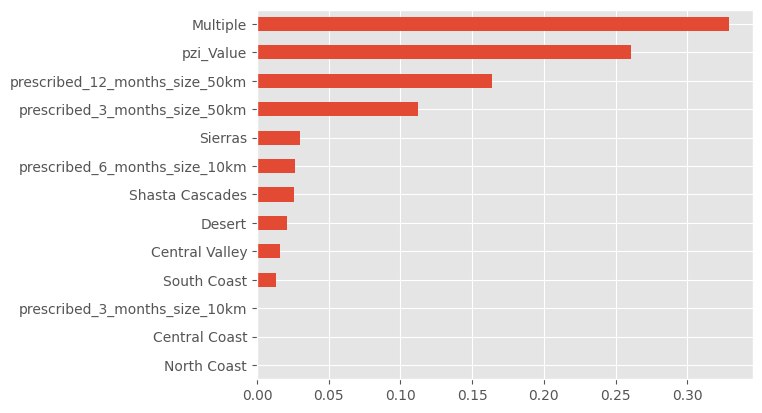

In [44]:
feat_importances = pd.Series(boost.feature_importances_, index=x_train.columns)
feat_importances.nlargest(len(selected_features)).plot(kind='barh').invert_yaxis()

In [45]:
results = pd.DataFrame({"Train MSE": train_mse,
                        "Test MSE": test_mse,
                        # "Train R^2": train_r,
                        # "Test R^2": test_r
                        }, index=models).round(3)

In [46]:
results

,Train MSE,Test MSE
linear regression,4.455,4.353
linear mixed effects model,5.319,4.954
lasso,4.457,4.345
ridge,4.454,4.330
random forest,0.971,5.271
adaboost,4.532,4.457


In [47]:
print(results.to_latex())

\begin{tabular}{lrr}
\toprule
 & Train MSE & Test MSE \\
\midrule
linear regression & 4.455000 & 4.353000 \\
linear mixed effects model & 5.319000 & 4.954000 \\
lasso & 4.457000 & 4.345000 \\
ridge & 4.454000 & 4.330000 \\
random forest & 0.971000 & 5.271000 \\
adaboost & 4.532000 & 4.457000 \\
\bottomrule
\end{tabular}



<Axes: ylabel='MSE'>

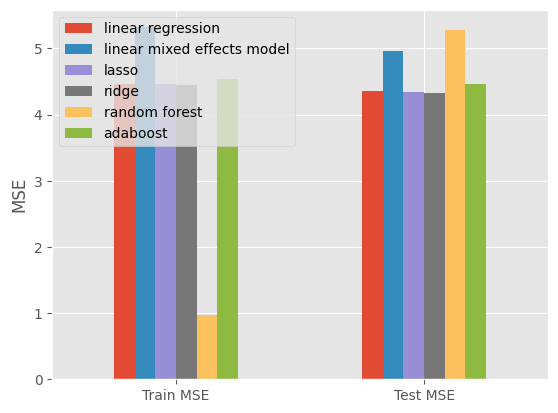

In [48]:
results.T.plot.bar(rot=0,  ylabel="MSE")

In [49]:
np.exp(4.6**(0.5))

8.540000436840169

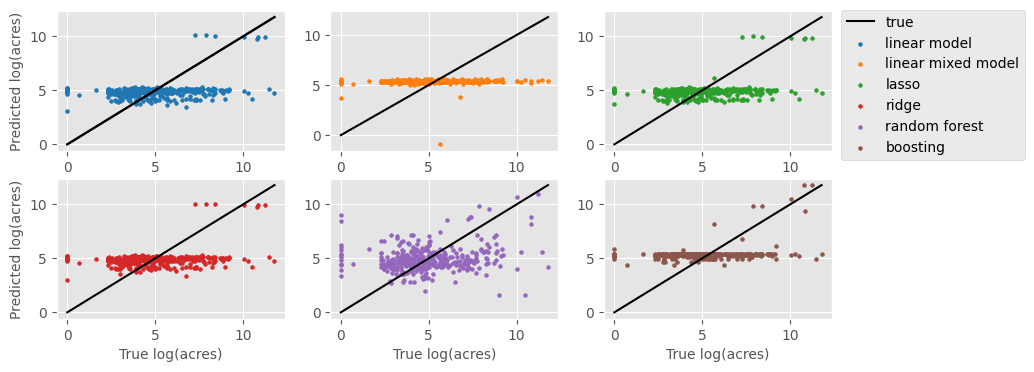

In [50]:
# plot true vs pred for each model
import matplotlib.cm as cm

linear_test = linear_model.predict(x_test_lm)
lasso_test = lasso.predict(x_test)
ridge_test = ridge.predict(x_test)
rf_test = rf.predict(x_test)
boost_test = boost.predict(x_test)
lm_test = mdf.predict(x_test_lmm[selected_linear_m_features+["constant"]])

errors_df = pd.DataFrame({"True log(acres)":y_test, "linear model":linear_test, "linear mixed model": lm_test,
                            "lasso": lasso_test, "ridge": ridge_test, 
                            "random forest": rf_test, "boosting": boost_test})
errors_df.sort_values("True log(acres)", inplace=True)

#fig = plt.figure()
fig, axs = plt.subplots(2, 3, figsize=(10,4))
row = 0
col = 0
colors =  cm.tab10(np.linspace(0, 1, 10))
c = 0
for mod in errors_df.columns:
    if mod != "True log(acres)":
        if c == 0: axs[row, col].plot(errors_df["True log(acres)"], errors_df["True log(acres)"], label="true", color="black")
        axs[row, col].scatter(errors_df["True log(acres)"], errors_df[mod], label=mod, s=7, color=colors[c])
        if row == 1: axs[row, col].set_xlabel("True log(acres)", fontsize=10)
        if col == 0:axs[row, col].set_ylabel("Predicted log(acres)", fontsize=10)
        col = col + 1
        c = c +1
        if col == 3:
            col = 0
            row = row + 1

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
row = 0
col = 0
for mod in errors_df.columns:
    if mod != "True log(acres)":
        axs[row, col].plot(errors_df["True log(acres)"], errors_df["True log(acres)"], label="true", color="black")
        col = col + 1
        if col == 3:
            col = 0
            row = row + 1

fig.legend(lines, labels,bbox_to_anchor=(1.1, 0.9), loc="upper right")
plt.show()